In [4]:
# !pip install datasets
# !pip install --upgrade pyarrow

## Data Preparation

In [16]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np

# Load your dataset
df = pd.read_csv('../data/train_reviews.csv', encoding='latin')

# Drop unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Ensure the labels are in the correct format
label_columns = ['Cinematography', 'Direction', 'Story', 'Characters', 'Production Design', 'Unique Concept', 'Emotions']
df[label_columns] = df[label_columns].astype(float)

# Create HuggingFace Dataset
dataset = Dataset.from_pandas(df)


### Load Model

In [6]:
torch.cuda.empty_cache()
# Load tokenizer and model
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-small')
model = DebertaV2ForSequenceClassification.from_pretrained('microsoft/deberta-v3-small', num_labels=len(label_columns)).to("cuda:0")
model.config.problem_type = "regression"


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:

# Ensure tokenizer and model vocabulary sizes match
vocab_size = len(tokenizer)

# Tokenize your data
def tokenize_function(example):
    return tokenizer(example['review'], padding='max_length', truncation=True, max_length=512)

# Check if token IDs are within vocabulary size
def check_vocab(example):
    input_ids = example['input_ids']
    if any(i >= vocab_size for i in input_ids):
        print(f"Found token ID out of bounds: {input_ids}")
    return example



In [8]:

# Convert labels to float32 for PyTorch
def format_labels(example):
    labels = [example[label] for label in label_columns]
    example['labels'] = torch.tensor(labels, dtype=torch.float32)
    return example


In [9]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.map(check_vocab)

tokenized_datasets = tokenized_datasets.map(format_labels)


Map: 100%|██████████| 48577/48577 [00:03<00:00, 13565.37 examples/s]


# TRAIN

In [17]:
from transformers import TrainingArguments, Trainer
import torch

# Define your training arguments
training_args = TrainingArguments(
    output_dir='./results',  # This still needs to be provided but will not be used
    evaluation_strategy="no",  # No evaluation during training
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=0,  # Do not save checkpoints
    save_steps=0,  # Do not save any checkpoints
    logging_strategy="no",  # Disable logging
    use_cpu=False,  # Force the training to run on CPU
)

# Define a custom compute_metrics function for regression
def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids
    mse = ((preds - labels) ** 2).mean().item()
    return {"mse": mse}

# Custom Trainer class to compute loss for regression
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,  # Change this to your actual eval dataset if separate
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model (using CPU for debugging)
trainer.train()


/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 121450/121450 [15:21:26<00:00,  2.20it/s]  

{'train_runtime': 55286.1561, 'train_samples_per_second': 8.786, 'train_steps_per_second': 2.197, 'train_loss': 0.028372473561650884, 'epoch': 10.0}


TrainOutput(global_step=121450, training_loss=0.028372473561650884, metrics={'train_runtime': 55286.1561, 'train_samples_per_second': 8.786, 'train_steps_per_second': 2.197, 'total_flos': 6.435671823307776e+16, 'train_loss': 0.028372473561650884, 'epoch': 10.0})

In [18]:
import gc 
gc.collect()

torch.cuda.empty_cache()

In [19]:
# Save the model
model.save_pretrained('./deberta-v3-fine-tuned')
tokenizer.save_pretrained('./deberta-v3-fine-tuned')

('./deberta-v3-fine-tuned/tokenizer_config.json',
 './deberta-v3-fine-tuned/special_tokens_map.json',
 './deberta-v3-fine-tuned/spm.model',
 './deberta-v3-fine-tuned/added_tokens.json',
 './deberta-v3-fine-tuned/tokenizer.json')

# TEST

In [20]:
import pandas as pd
from datasets import Dataset
import csv


# Load test data from CSV
test_data_path = '../data/test_reviews.csv'  # Update with your test data path

# Drop unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Ensure the labels are in the correct format
label_columns = ['Cinematography', 'Direction', 'Story', 'Characters', 'Production Design', 'Unique Concept', 'Emotions']
df[label_columns] = df[label_columns].astype(float)


# Read CSV file properly handling commas in the reviews
rows = []
with open(test_data_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    headers = next(reader)
    for row in reader:
        review = ','.join(row[:-7])
        scores = row[-7:]
        rows.append([review] + scores)

# Create DataFrame
test_df = pd.DataFrame(rows, columns=headers)

# Convert DataFrame to Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset

Dataset({
    features: ['review', 'Cinematography', 'Direction', 'Story', 'Characters', 'Production Design', 'Unique Concept', 'Emotions'],
    num_rows: 793
})

In [21]:
# Load tokenizer and model (replace 'path/to/model' with the actual path)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch

tokenizer = AutoTokenizer.from_pretrained('./deberta-v3-fine-tuned')
model = AutoModelForSequenceClassification.from_pretrained('./deberta-v3-fine-tuned')
model.config.problem_type = "regression"


In [22]:
import pandas as pd
from datasets import Dataset
import csv
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import numpy as np

# Load test data from CSV
test_data_path = '../data/test_reviews.csv'  # Update with your test data path

# Read CSV file properly handling commas in the reviews
rows = []
with open(test_data_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    headers = next(reader)
    for row in reader:
        review = ','.join(row[:-7])
        scores = row[-7:]
        rows.append([review] + scores)

# Create DataFrame
test_df = pd.DataFrame(rows, columns=headers)

# Drop unnecessary column if it exists
if 'Unnamed: 0' in test_df.columns:
    test_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Ensure the labels are in the correct format
label_columns = ['Cinematography', 'Direction', 'Story', 'Characters', 'Production Design', 'Unique Concept', 'Emotions']
test_df[label_columns] = test_df[label_columns].astype(float)

# Convert DataFrame to Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer and model (replace 'path/to/model' with the actual path)
tokenizer = AutoTokenizer.from_pretrained('./deberta-v3-fine-tuned')
model = AutoModelForSequenceClassification.from_pretrained('./deberta-v3-fine-tuned')
model.config.problem_type = "regression"

# Ensure tokenizer and model vocabulary sizes match
vocab_size = len(tokenizer)

# Tokenize your data
def tokenize_function(example):
    return tokenizer(example['review'], padding='max_length', truncation=True, max_length=512)

# Check if token IDs are within vocabulary size
def check_vocab(example):
    input_ids = example['input_ids']
    if any(i >= vocab_size for i in input_ids):
        print(f"Found token ID out of bounds: {input_ids}")
    return example

# Convert labels to float32 for PyTorch
def format_labels(example):
    labels = [float(example[label]) for label in label_columns]
    example['labels'] = torch.tensor(labels, dtype=torch.float32)
    return example

# Tokenize and format the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.map(check_vocab)
tokenized_test_dataset = tokenized_test_dataset.map(format_labels)

# Define a custom compute_metrics function for regression
def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids
    mse = mean_squared_error(labels, preds)
    return {"mse": mse}

# Custom Trainer class to compute loss for regression
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer (without training)
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=0,
    save_steps=0,
    logging_strategy="no",
    use_cpu=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=None,  # No training dataset
    eval_dataset=tokenized_test_dataset,  # Use the tokenized test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(tokenized_test_dataset)

# Get predictions and true labels
predictions = trainer.predict(tokenized_test_dataset)
preds = predictions.predictions
labels = predictions.label_ids

# Compute MSE
mse = mean_squared_error(labels, preds)
print(f"Mean Squared Error: {mse}")

# Convert predictions and labels to integers for confusion matrix
preds_class = np.round(preds).astype(int)
labels_class = np.round(labels).astype(int)

# Print classification report and confusion matrix for each label
for i, label in enumerate(label_columns):
    print(f"\nClassification Report for {label}:")
    print(classification_report(labels_class[:, i], preds_class[:, i]))
    print(f"Confusion Matrix for {label}:")
    print(confusion_matrix(labels_class[:, i], preds_class[:, i]))

# Print the evaluation results
print("Test Results:", test_results)


Map: 100%|██████████| 793/793 [00:00<00:00, 10220.27 examples/s]
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 199/199 [00:23<00:00,  8.58it/s]

Mean Squared Error: 0.08594679832458496

Classification Report for Cinematography:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99        68
           0       1.00      0.91      0.95       415
           1       0.89      1.00      0.94       310

    accuracy                           0.95       793
   macro avg       0.96      0.97      0.96       793
weighted avg       0.96      0.95      0.95       793

Confusion Matrix for Cinematography:
[[ 68   0   0]
 [  1 377  37]
 [  0   0 310]]

Classification Report for Direction:
              precision    recall  f1-score   support

          -1       0.81      0.99      0.89       137
           0       0.99      0.92      0.95       408
           1       0.99      1.00      0.99       248

    accuracy                           0.95       793
   macro avg       0.93      0.97      0.94       793
weighted avg       0.96      0.95      0.95       793

Confusion Matrix for Direction:
[[

Map: 100%|██████████| 793/793 [00:00<00:00, 11310.86 examples/s]
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 199/199 [00:23<00:00,  8.29it/s]


Mean Squared Error: 0.005140079651027918

Classification Report for Cinematography:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99        68
           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00       310

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Cinematography:
[[ 68   0   0]
 [  1 414   0]
 [  0   0 310]]


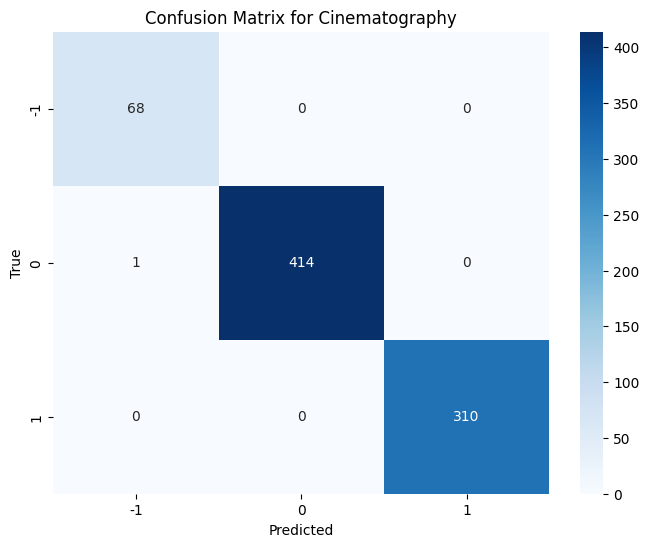


Classification Report for Direction:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       137
           0       1.00      1.00      1.00       408
           1       1.00      1.00      1.00       248

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Direction:
[[137   0   0]
 [  0 407   1]
 [  0   0 248]]


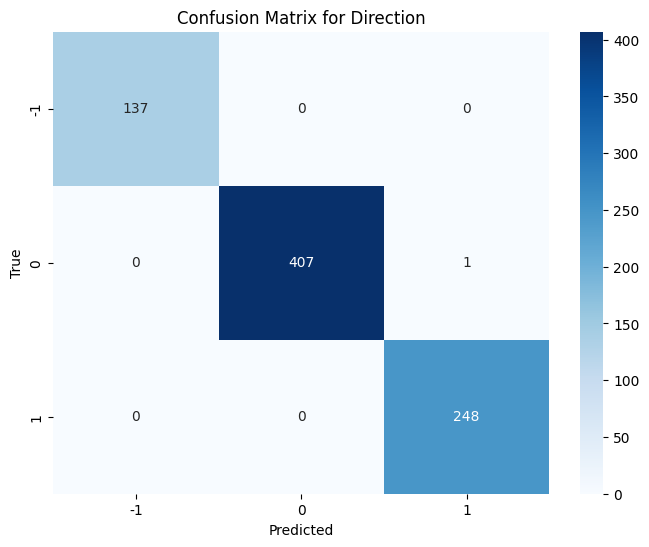


Classification Report for Story:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       109
           0       0.99      0.98      0.99       383
           1       0.98      0.98      0.98       301

    accuracy                           0.99       793
   macro avg       0.99      0.99      0.99       793
weighted avg       0.99      0.99      0.99       793

Confusion Matrix for Story:
[[109   0   0]
 [  0 377   6]
 [  0   5 296]]


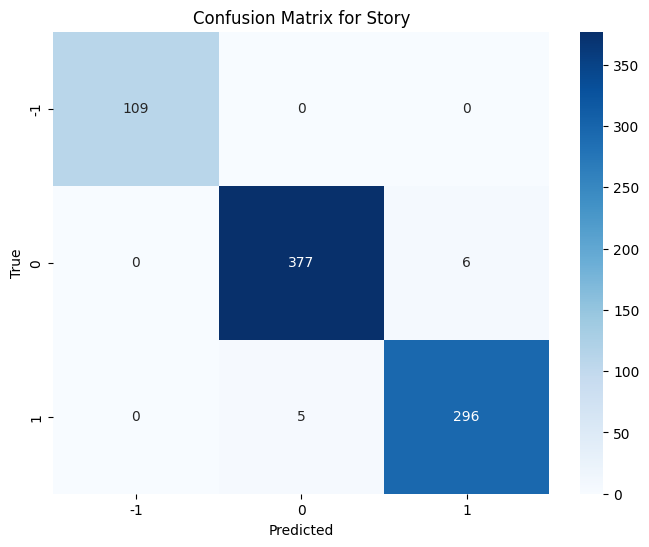


Classification Report for Characters:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       168
           0       1.00      0.96      0.98       253
           1       0.97      1.00      0.98       372

    accuracy                           0.98       793
   macro avg       0.99      0.98      0.99       793
weighted avg       0.99      0.98      0.98       793

Confusion Matrix for Characters:
[[168   0   0]
 [  0 242  11]
 [  0   1 371]]


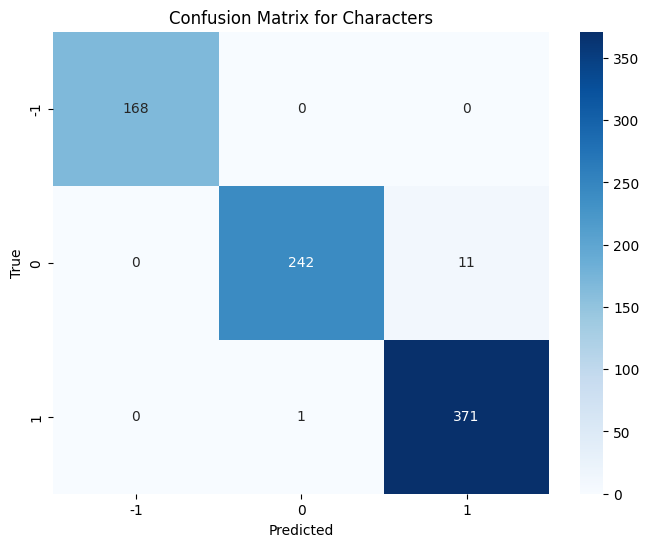


Classification Report for Production Design:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        34
           0       1.00      1.00      1.00       550
           1       1.00      1.00      1.00       209

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Production Design:
[[ 34   0   0]
 [  0 550   0]
 [  0   1 208]]


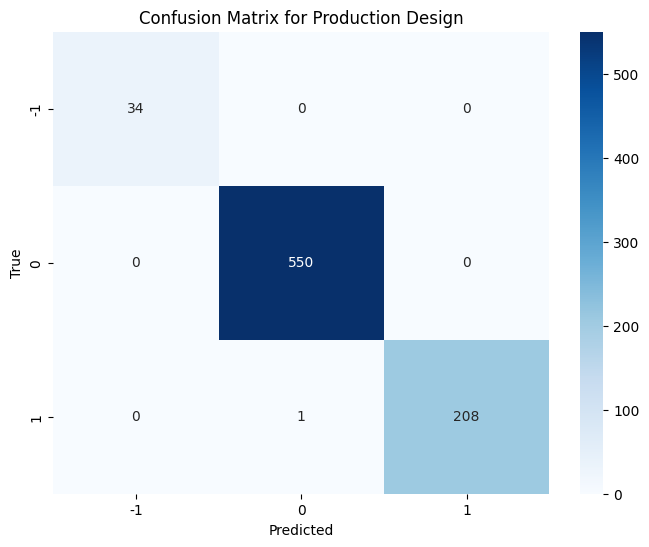


Classification Report for Unique Concept:
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         1
           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00       339

    accuracy                           1.00       793
   macro avg       0.83      1.00      0.89       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Unique Concept:
[[  1   0   0]
 [  1 452   0]
 [  0   0 339]]


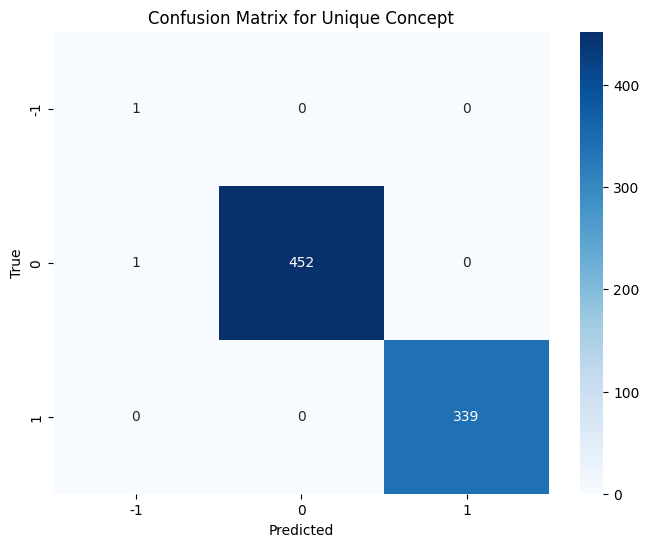


Classification Report for Emotions:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        99
           0       0.99      0.99      0.99       621
           1       0.95      0.95      0.95        73

    accuracy                           0.99       793
   macro avg       0.98      0.98      0.98       793
weighted avg       0.99      0.99      0.99       793

Confusion Matrix for Emotions:
[[ 99   0   0]
 [  0 617   4]
 [  0   4  69]]


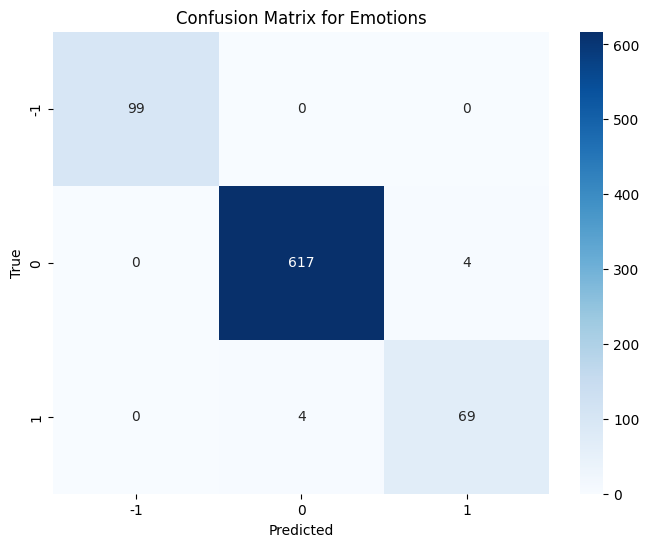

Test Results: {'eval_loss': 0.005140079651027918, 'eval_model_preparation_time': 0.0009, 'eval_mse': 0.005140079651027918, 'eval_runtime': 23.5861, 'eval_samples_per_second': 33.621, 'eval_steps_per_second': 8.437}


In [31]:
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure tokenizer and model vocabulary sizes match
vocab_size = len(tokenizer)

# Tokenize your data
def tokenize_function(example):
    return tokenizer(example['review'], padding='max_length', truncation=True, max_length=512)

# Check if token IDs are within vocabulary size
def check_vocab(example):
    input_ids = example['input_ids']
    if any(i >= vocab_size for i in input_ids):
        print(f"Found token ID out of bounds: {input_ids}")
    return example

# Convert labels to float32 for PyTorch
def format_labels(example):
    labels = [float(example[label]) for label in label_columns]
    example['labels'] = torch.tensor(labels, dtype=torch.float32)
    return example

# Tokenize and format the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.map(check_vocab)
tokenized_test_dataset = tokenized_test_dataset.map(format_labels)

# Define a custom compute_metrics function for regression
def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids
    mse = mean_squared_error(labels, preds)
    return {"mse": mse}

# Custom Trainer class to compute loss for regression
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer (without training)
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=0,
    save_steps=0,
    logging_strategy="no",
    use_cpu=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=None,  # No training dataset
    eval_dataset=tokenized_test_dataset,  # Use the tokenized test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(tokenized_test_dataset)

# Get predictions and true labels
predictions = trainer.predict(tokenized_test_dataset)
preds = predictions.predictions
labels = predictions.label_ids

# Compute MSE
mse = mean_squared_error(labels, preds)
print(f"Mean Squared Error: {mse}")

# Convert predictions and labels to integers for confusion matrix
preds_class = np.round(preds).astype(int)
labels_class = np.round(labels).astype(int)

# Plotting Confusion Matrix
for i, label in enumerate(label_columns):
    print(f"\nClassification Report for {label}:")
    print(classification_report(labels_class[:, i], preds_class[:, i]))
    print(f"Confusion Matrix for {label}:")
    print(confusion_matrix(labels_class[:, i], preds_class[:, i]))

    # Plot confusion matrix
    cm = confusion_matrix(labels_class[:, i], preds_class[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Print the evaluation results
print("Test Results:", test_results)


Map: 100%|██████████| 793/793 [00:00<00:00, 9754.48 examples/s]
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 10%|█         | 199/1990 [01:22<10:34,  2.82it/s]

{'loss': 0.0173, 'grad_norm': 0.8499308228492737, 'learning_rate': 1.8e-05, 'epoch': 1.0}



 10%|█         | 199/1990 [01:47<10:34,  2.82it/s]

{'eval_loss': 0.005214557517319918, 'eval_mse': 0.005214552860707045, 'eval_runtime': 25.1613, 'eval_samples_per_second': 31.517, 'eval_steps_per_second': 7.909, 'epoch': 1.0}


 20%|██        | 398/1990 [03:19<10:02,  2.64it/s]  

{'loss': 0.0075, 'grad_norm': 0.818537175655365, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}



 20%|██        | 398/1990 [03:45<10:02,  2.64it/s]

{'eval_loss': 0.0043432097882032394, 'eval_mse': 0.004343208856880665, 'eval_runtime': 26.1863, 'eval_samples_per_second': 30.283, 'eval_steps_per_second': 7.599, 'epoch': 2.0}


 30%|███       | 597/1990 [05:19<08:44,  2.66it/s]  

{'loss': 0.006, 'grad_norm': 0.5954776406288147, 'learning_rate': 1.4e-05, 'epoch': 3.0}



 30%|███       | 597/1990 [05:45<08:44,  2.66it/s]

{'eval_loss': 0.003949674777686596, 'eval_mse': 0.003949672915041447, 'eval_runtime': 26.2555, 'eval_samples_per_second': 30.203, 'eval_steps_per_second': 7.579, 'epoch': 3.0}


 40%|████      | 796/1990 [07:18<07:29,  2.66it/s]  

{'loss': 0.0053, 'grad_norm': 0.6950127482414246, 'learning_rate': 1.2e-05, 'epoch': 4.0}



 40%|████      | 796/1990 [07:44<07:29,  2.66it/s]

{'eval_loss': 0.003951245453208685, 'eval_mse': 0.003951246850192547, 'eval_runtime': 26.1794, 'eval_samples_per_second': 30.291, 'eval_steps_per_second': 7.601, 'epoch': 4.0}


 50%|█████     | 995/1990 [09:17<06:16,  2.64it/s]  

{'loss': 0.005, 'grad_norm': 0.5213469862937927, 'learning_rate': 1e-05, 'epoch': 5.0}



 50%|█████     | 995/1990 [09:43<06:16,  2.64it/s]

{'eval_loss': 0.003528143046423793, 'eval_mse': 0.0035281393211334944, 'eval_runtime': 26.3803, 'eval_samples_per_second': 30.06, 'eval_steps_per_second': 7.543, 'epoch': 5.0}


 60%|██████    | 1194/1990 [11:16<05:00,  2.65it/s] 

{'loss': 0.0042, 'grad_norm': 0.25063860416412354, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}



 60%|██████    | 1194/1990 [11:42<05:00,  2.65it/s]

{'eval_loss': 0.0022963027004152536, 'eval_mse': 0.0022963022347539663, 'eval_runtime': 26.3779, 'eval_samples_per_second': 30.063, 'eval_steps_per_second': 7.544, 'epoch': 6.0}


 70%|███████   | 1393/1990 [13:15<03:45,  2.65it/s]  

{'loss': 0.0039, 'grad_norm': 0.7023897767066956, 'learning_rate': 6e-06, 'epoch': 7.0}



 70%|███████   | 1393/1990 [13:42<03:45,  2.65it/s]

{'eval_loss': 0.003013548208400607, 'eval_mse': 0.003013548906892538, 'eval_runtime': 26.4673, 'eval_samples_per_second': 29.961, 'eval_steps_per_second': 7.519, 'epoch': 7.0}


 80%|████████  | 1592/1990 [15:15<02:30,  2.65it/s]  

{'loss': 0.004, 'grad_norm': 0.30051669478416443, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}



 80%|████████  | 1592/1990 [15:41<02:30,  2.65it/s]

{'eval_loss': 0.002434283262118697, 'eval_mse': 0.0024342837277799845, 'eval_runtime': 26.5548, 'eval_samples_per_second': 29.863, 'eval_steps_per_second': 7.494, 'epoch': 8.0}


 90%|█████████ | 1791/1990 [17:15<01:15,  2.64it/s]  

{'loss': 0.0037, 'grad_norm': 0.2768501341342926, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}



 90%|█████████ | 1791/1990 [17:42<01:15,  2.64it/s]

{'eval_loss': 0.0023903942201286554, 'eval_mse': 0.0023903942201286554, 'eval_runtime': 26.8544, 'eval_samples_per_second': 29.53, 'eval_steps_per_second': 7.41, 'epoch': 9.0}


100%|██████████| 1990/1990 [19:17<00:00,  2.64it/s]

{'loss': 0.0036, 'grad_norm': 0.5736538171768188, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 1990/1990 [19:44<00:00,  2.64it/s]

{'eval_loss': 0.0024620951153337955, 'eval_mse': 0.0024620944168418646, 'eval_runtime': 26.9358, 'eval_samples_per_second': 29.44, 'eval_steps_per_second': 7.388, 'epoch': 10.0}


100%|██████████| 1990/1990 [19:46<00:00,  1.68it/s]


{'train_runtime': 1186.9473, 'train_samples_per_second': 6.681, 'train_steps_per_second': 1.677, 'train_loss': 0.006056368950024322, 'epoch': 10.0}


100%|██████████| 199/199 [00:26<00:00,  7.38it/s]


Mean Squared Error: 0.0024620944168418646

Classification Report for Cinematography:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        68
           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00       310

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Cinematography:
[[ 68   0   0]
 [  0 415   0]
 [  0   0 310]]


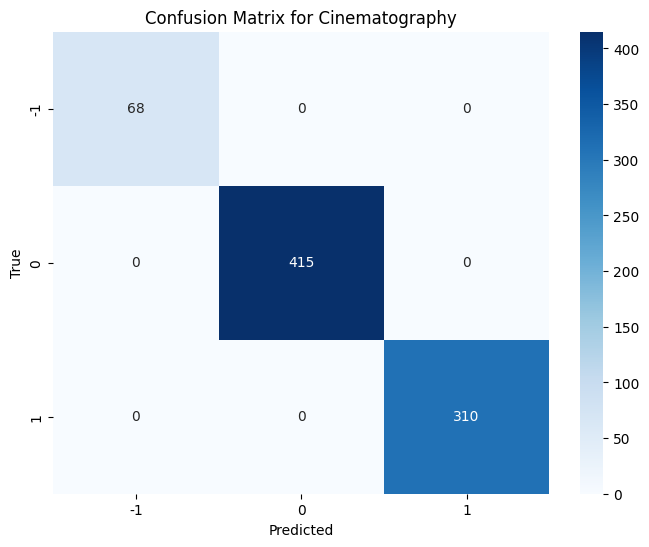


Classification Report for Direction:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       137
           0       1.00      1.00      1.00       408
           1       1.00      1.00      1.00       248

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Direction:
[[137   0   0]
 [  0 408   0]
 [  0   0 248]]


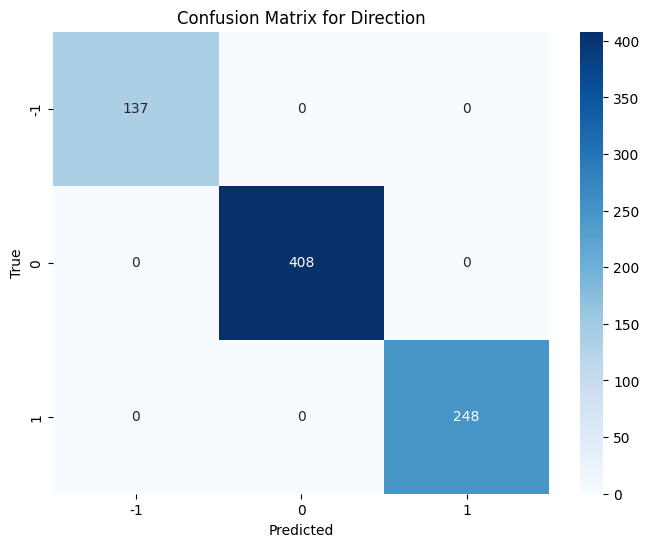


Classification Report for Story:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       109
           0       1.00      0.97      0.99       383
           1       0.96      1.00      0.98       301

    accuracy                           0.99       793
   macro avg       0.99      0.99      0.99       793
weighted avg       0.99      0.99      0.99       793

Confusion Matrix for Story:
[[109   0   0]
 [  0 372  11]
 [  0   0 301]]


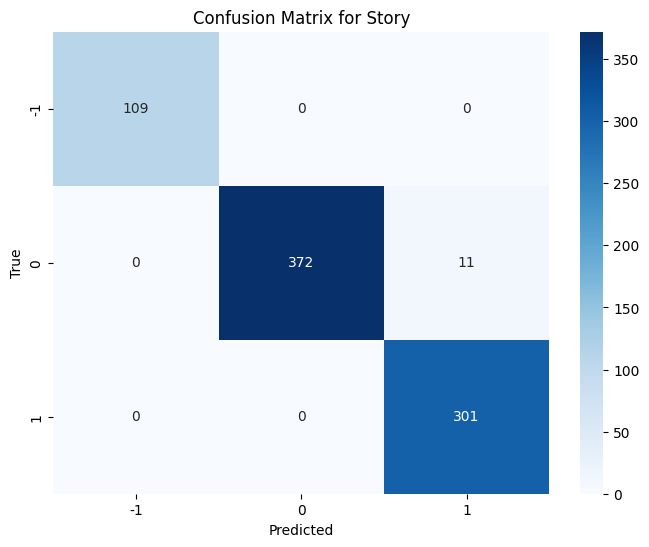


Classification Report for Characters:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       168
           0       1.00      0.96      0.98       253
           1       0.97      1.00      0.99       372

    accuracy                           0.99       793
   macro avg       0.99      0.99      0.99       793
weighted avg       0.99      0.99      0.99       793

Confusion Matrix for Characters:
[[168   0   0]
 [  0 243  10]
 [  0   0 372]]


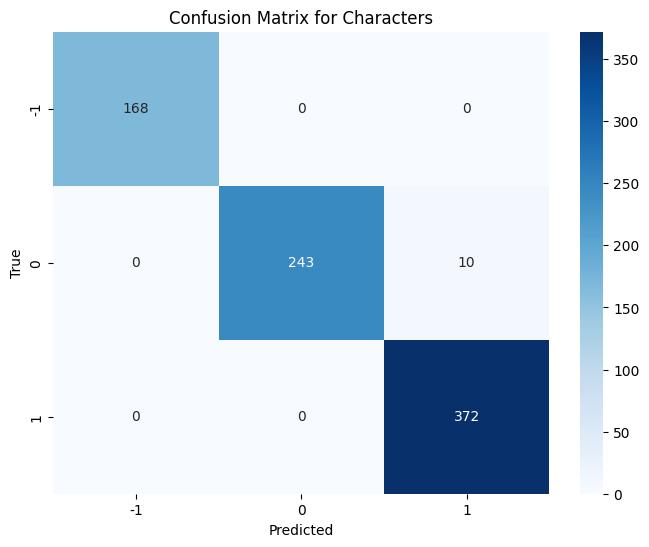


Classification Report for Production Design:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        34
           0       1.00      1.00      1.00       550
           1       1.00      1.00      1.00       209

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Production Design:
[[ 34   0   0]
 [  0 550   0]
 [  0   0 209]]


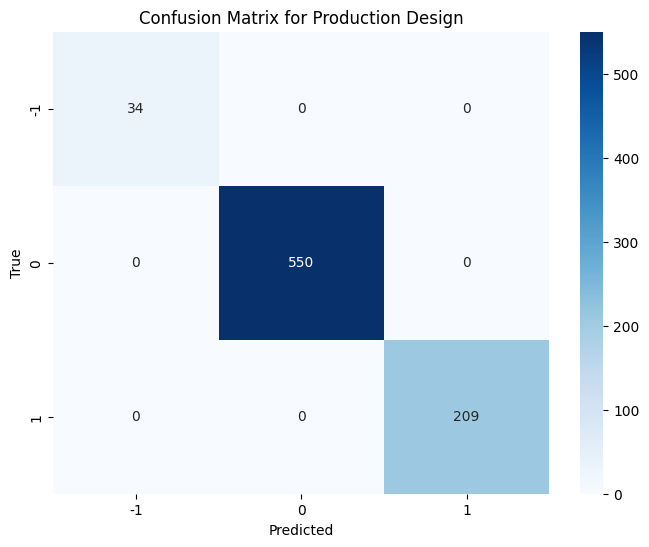


Classification Report for Unique Concept:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         1
           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00       339

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793

Confusion Matrix for Unique Concept:
[[  1   0   0]
 [  0 453   0]
 [  0   0 339]]


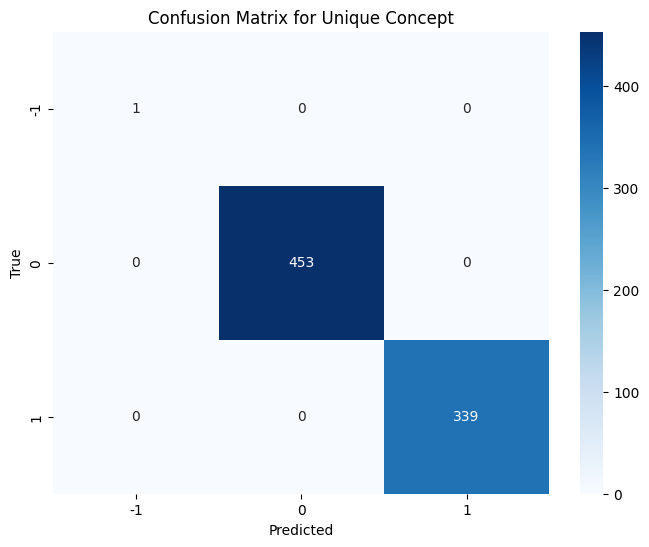


Classification Report for Emotions:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        99
           0       1.00      0.99      1.00       621
           1       0.95      1.00      0.97        73

    accuracy                           0.99       793
   macro avg       0.98      1.00      0.99       793
weighted avg       1.00      0.99      1.00       793

Confusion Matrix for Emotions:
[[ 99   0   0]
 [  0 617   4]
 [  0   0  73]]


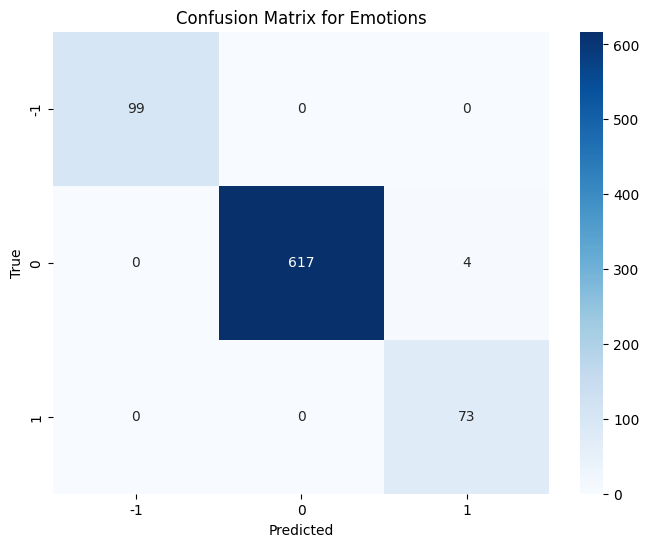

In [34]:
import pandas as pd
from datasets import Dataset
import csv
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load test data from CSV
test_data_path = '../data/test_reviews.csv'  # Update with your test data path

# Read CSV file properly handling commas in the reviews
rows = []
with open(test_data_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    headers = next(reader)
    for row in reader:
        review = ','.join(row[:-7])
        scores = row[-7:]
        rows.append([review] + scores)

# Create DataFrame
test_df = pd.DataFrame(rows, columns=headers)

# Drop unnecessary column if it exists
if 'Unnamed: 0' in test_df.columns:
    test_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Ensure the labels are in the correct format
label_columns = ['Cinematography', 'Direction', 'Story', 'Characters', 'Production Design', 'Unique Concept', 'Emotions']
test_df[label_columns] = test_df[label_columns].astype(float)

# Convert DataFrame to Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer and model (replace 'path/to/model' with the actual path)
tokenizer = AutoTokenizer.from_pretrained('./deberta-v3-fine-tuned')
model = AutoModelForSequenceClassification.from_pretrained('./deberta-v3-fine-tuned')
model.config.problem_type = "regression"

# Ensure tokenizer and model vocabulary sizes match
vocab_size = len(tokenizer)

# Tokenize your data
def tokenize_function(example):
    return tokenizer(example['review'], padding='max_length', truncation=True, max_length=512)

# Check if token IDs are within vocabulary size
def check_vocab(example):
    input_ids = example['input_ids']
    if any(i >= vocab_size for i in input_ids):
        print(f"Found token ID out of bounds: {input_ids}")
    return example

# Convert labels to float32 for PyTorch
def format_labels(example):
    labels = [float(example[label]) for label in label_columns]
    example['labels'] = torch.tensor(labels, dtype=torch.float32)
    return example

# Tokenize and format the test dataset
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.map(check_vocab)
tokenized_test_dataset = tokenized_test_dataset.map(format_labels)

# Define a custom compute_metrics function for regression
def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids
    mse = mean_squared_error(labels, preds)
    return {"mse": mse}

# Custom Trainer class to compute loss for regression
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer with logging enabled
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    logging_strategy="epoch",  # Log every epoch
    save_strategy="epoch",  # Save checkpoint every epoch
    use_cpu=False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_test_dataset,  # Use the tokenized test dataset for both training and evaluation
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
train_result = trainer.train()

# Evaluate the model on the test dataset
test_results = trainer.evaluate(tokenized_test_dataset)

# Get predictions and true labels
predictions = trainer.predict(tokenized_test_dataset)
preds = predictions.predictions
labels = predictions.label_ids

# Compute MSE
mse = mean_squared_error(labels, preds)
print(f"Mean Squared Error: {mse}")

# Convert predictions and labels to integers for confusion matrix
preds_class = np.round(preds).astype(int)
labels_class = np.round(labels).astype(int)

# Plotting Confusion Matrix
for i, label in enumerate(label_columns):
    print(f"\nClassification Report for {label}:")
    print(classification_report(labels_class[:, i], preds_class[:, i]))
    print(f"Confusion Matrix for {label}:")
    print(confusion_matrix(labels_class[:, i], preds_class[:, i]))

    # Plot confusion matrix
    cm = confusion_matrix(labels_class[:, i], preds_class[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

100%|██████████| 199/199 [00:26<00:00,  7.39it/s]


Mean Squared Error: 0.0024620944168418646


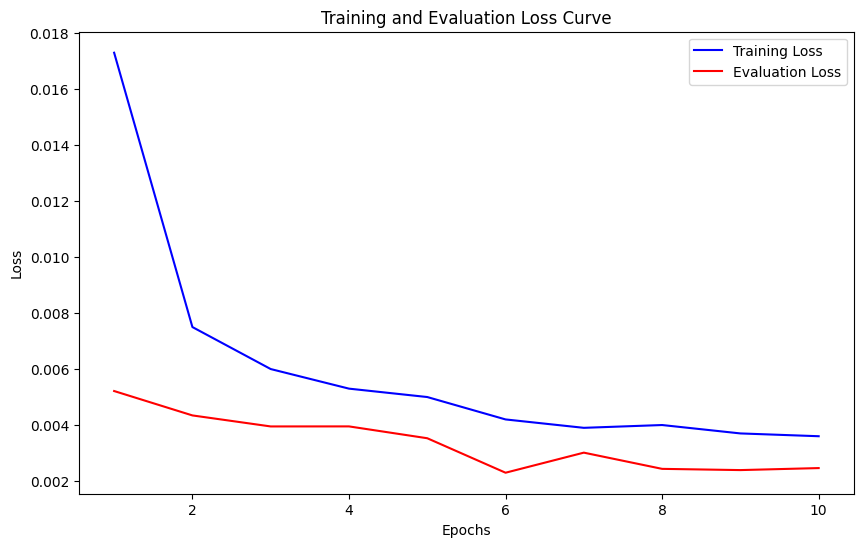

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
predictions = trainer.predict(tokenized_test_dataset)
preds = predictions.predictions
labels = predictions.label_ids

# Compute MSE
mse = mean_squared_error(labels, preds)
print(f"Mean Squared Error: {mse}")

# Convert predictions and labels to integers for confusion matrix
preds_class = np.round(preds).astype(int)
labels_class = np.round(labels).astype(int)


# Plotting Loss Curve
log_history = trainer.state.log_history
train_loss = [x['loss'] for x in log_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]

# Ensure both lists have the same length
min_length = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, eval_loss, 'r-', label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curve')
plt.legend()
plt.show()
